<h1><center>Laboratorio 6: Optimización de modelos 🧪</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos - Otoño 2025</strong></center>

### Cuerpo Docente:

- Profesores: Stefano Schiappacasse, Sebastián Tinoco
- Auxiliares: Melanie Peña, Valentina Rojas
- Ayudantes: Angelo Muñoz, Valentina Zúñiga

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Esteban Rojas

### **Link de repositorio de GitHub:** https://github.com/esteban126/MDS7202

### Temas a tratar

- Predicción de demanda usando `xgboost`
- Búsqueda del modelo óptimo de clasificación usando `optuna`
- Uso de pipelines.


### Reglas:

- **Grupos de 2 personas**
- Fecha de entrega: 6 días de plazo con descuento de 1 punto por día. Entregas Martes a las 23:59.
- Instrucciones del lab el viernes a las 16:15 en formato online. Asistencia no es obligatoria, pero se recomienda fuertemente asistir.
- <u>Prohibidas las copias</u>. Cualquier intento de copia será debidamente penalizado con el reglamento de la escuela.
- Tienen que subir el laboratorio a u-cursos y a su repositorio de github. Labs que no estén en u-cursos no serán revisados. Recuerden que el repositorio también tiene nota.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Pueden usar cualquier material del curso que estimen conveniente.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# Importamos librerias útiles

In [128]:
!pip install -qq xgboost optuna

In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# El emprendimiento de Fiu

Tras liderar de manera exitosa la implementación de un proyecto de ciencia de datos para caracterizar los datos generados en Santiago 2023, el misterioso corpóreo **Fiu** se anima y decide levantar su propio negocio de consultoría en machine learning. Tras varias e intensas negociaciones, Fiu logra encontrar su *primera chamba*: predecir la demanda (cantidad de venta) de una famosa productora de bebidas de calibre mundial. Al ver el gran potencial y talento que usted ha demostrado en el campo de la ciencia de datos, Fiu lo contrata como data scientist para que forme parte de su nuevo emprendimiento.

Para este laboratorio deben trabajar con los datos `sales.csv` subidos a u-cursos, el cual contiene una muestra de ventas de la empresa para diferentes productos en un determinado tiempo.

Para comenzar, cargue el dataset señalado y visualice a través de un `.head` los atributos que posee el dataset.

<i><p align="center">Fiu siendo felicitado por su excelente desempeño en el proyecto de caracterización de datos</p></i>
<p align="center">
  <img src="https://media-front.elmostrador.cl/2023/09/A_UNO_1506411_2440e.jpg">
</p>

In [130]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv('/content/drive/MyDrive/sales.csv')

df.head()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,0,31/01/12,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,glass,500ml,0.96,13280
1,1,31/01/12,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,plastic,1.5lt,2.86,6727
2,2,31/01/12,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,can,330ml,0.87,9848
3,3,31/01/12,Athens,37.97945,23.71622,672130,shop_1,adult-cola,glass,500ml,1.00,20050
4,4,31/01/12,Athens,37.97945,23.71622,672130,shop_1,adult-cola,can,330ml,0.39,25696


## 1 Generando un Baseline (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/O-lan6TkadUAAAAC/what-i-wnna-do-after-a-baseline.gif">
</p>

Antes de entrenar un algoritmo, usted recuerda los apuntes de su magíster en ciencia de datos y recuerda que debe seguir una serie de *buenas prácticas* para entrenar correcta y debidamente su modelo. Después de un par de vueltas, llega a las siguientes tareas:

1. Separe los datos en conjuntos de train (70%), validation (20%) y test (10%). Fije una semilla para controlar la aleatoriedad. [0.5 puntos]
2. Implemente un `FunctionTransformer` para extraer el día, mes y año de la variable `date`. Guarde estas variables en el formato categorical de pandas. [1 punto]
3. Implemente un `ColumnTransformer` para procesar de manera adecuada los datos numéricos y categóricos. Use `OneHotEncoder` para las variables categóricas. `Nota:` Utilice el método `.set_output(transform='pandas')` para obtener un DataFrame como salida del `ColumnTransformer` [1 punto]
4. Guarde los pasos anteriores en un `Pipeline`, dejando como último paso el regresor `DummyRegressor` para generar predicciones en base a promedios. [0.5 punto]
5. Entrene el pipeline anterior y reporte la métrica `mean_absolute_error` sobre los datos de validación. ¿Cómo se interpreta esta métrica para el contexto del negocio? [0.5 puntos]
6. Finalmente, vuelva a entrenar el `Pipeline` pero esta vez usando `XGBRegressor` como modelo **utilizando los parámetros por default**. ¿Cómo cambia el MAE al implementar este algoritmo? ¿Es mejor o peor que el `DummyRegressor`? [1 punto]
7. Guarde ambos modelos en un archivo .pkl (uno cada uno) [0.5 puntos]

In [131]:
from sklearn import set_config
set_config(transform_output="pandas")
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import pickle

# Supongamos que df ya está cargado y contiene la columna 'date' y 'target'
df['date'] = pd.to_datetime(df['date'])

RANDOM_SEED = 42

# División
train_val, test = train_test_split(df, test_size=0.10, random_state=RANDOM_SEED)
train, val = train_test_split(train_val, test_size=2/9, random_state=RANDOM_SEED)  # 2/9 ~ 20% de 90%

<ipython-input-131-dc940946eb3c>:13: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [132]:
def extract_date_features(X):
    df_ = pd.DataFrame()
    df_['day'] = X.dt.day.astype('category')
    df_['month'] = X.dt.month.astype('category')
    df_['year'] = X.dt.year.astype('category')
    return df_

date_transformer = FunctionTransformer(extract_date_features)

In [133]:
# Asumimos que 'target' es la variable a predecir
target = 'quantity'

# Separar features y target
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]

# Aplicamos el extractor de fecha sobre la columna 'date'
X_train_dates = date_transformer.fit_transform(X_train['date'])
X_val_dates = date_transformer.transform(X_val['date'])

# Añadimos features de fecha al dataset
X_train = X_train.drop(columns='date').join(X_train_dates)
X_val = X_val.drop(columns='date').join(X_val_dates)

# Identificamos tipos de variables
categorical_cols = X_train.select_dtypes(include=['category','object']).columns.tolist()
numeric_cols = X_train.select_dtypes(include='number').columns.tolist()

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), categorical_cols)
])
preprocessor.set_output(transform='pandas')

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['id', 'lat', 'long', 'pop', 'price']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['city', 'shop', 'brand', 'container',
                                  'capacity', 'day', 'month', 'year'])])

In [134]:
pipe_dummy = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DummyRegressor(strategy='mean'))
])

In [135]:
pipe_dummy.fit(X_train, y_train)
y_pred_dummy = pipe_dummy.predict(X_val)

mae_dummy = mean_absolute_error(y_val, y_pred_dummy)
print(f"MAE DummyRegressor: {mae_dummy:.2f}")

MAE DummyRegressor: 13543.96


En el contexto del negocio esta métrica te permite saber cuanto en promedio está alejado la cantidad real de productos que se vende vs la predicha por el modelo.

In [136]:
pipe_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=RANDOM_SEED))
])

pipe_xgb.fit(X_train, y_train)
y_pred_xgb = pipe_xgb.predict(X_val)

mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
print(f"MAE XGBRegressor: {mae_xgb:.2f}")

MAE XGBRegressor: 2456.05


Definitivamente, es mejor el algoritmo XGBRegressor por sobre el Dummy

In [137]:
with open('modelo_dummy.pkl', 'wb') as f:
    pickle.dump(pipe_dummy, f)

with open('modelo_xgb.pkl', 'wb') as f:
    pickle.dump(pipe_xgb, f)

## 2. Forzando relaciones entre parámetros con XGBoost (10 puntos)

<p align="center">
  <img src="https://64.media.tumblr.com/14cc45f9610a6ee341a45fd0d68f4dde/20d11b36022bca7b-bf/s640x960/67ab1db12ff73a530f649ac455c000945d99c0d6.gif">
</p>

Un colega aficionado a la economía le *sopla* que la demanda guarda una relación inversa con el precio del producto. Motivado para impresionar al querido corpóreo, se propone hacer uso de esta información para mejorar su modelo realizando las siguientes tareas:

1. Vuelva a entrenar el `Pipeline` con `XGBRegressor`, pero esta vez forzando una relación monótona negativa entre el precio y la cantidad. Para aplicar esta restricción apóyese en la siguiente <a href = https://xgboost.readthedocs.io/en/stable/tutorials/monotonic.html>documentación</a>. [6 puntos]

>Hint 1: Para implementar el constraint se le sugiere hacerlo especificando el nombre de la variable. De ser así, probablemente le sea útil **mantener el formato de pandas** antes del step de entrenamiento.

>Hint 2: Puede obtener el nombre de las columnas en el paso anterior al modelo regresor mediante el método `.get_feature_names_out()`

2. Luego, vuelva a reportar el `MAE` sobre el conjunto de validación. [1 puntos]

3. ¿Cómo cambia el error al incluir esta relación? ¿Tenía razón su amigo? [2 puntos]

4. Guarde su modelo en un archivo .pkl [1 punto]

In [138]:
from xgboost import XGBRegressor
# Obtener nombres finales de columnas
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

# Creamos un diccionario con las restricciones
# Queremos forzar una relación decreciente con la columna original 'price'
# Esa columna fue escalada, así que su nombre comienza con 'num__'
monotone_constraints_dict = {
    name: -1 if name == 'num__price' else 0
    for name in feature_names
}

# Creamos el modelo con el diccionario de restricciones
xgb_mono = XGBRegressor(
    monotone_constraints=monotone_constraints_dict,
    enable_categorical=True,
    random_state=RANDOM_SEED
)

# Creamos el pipeline
pipe_xgb_mono = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_mono)
])

# Entrenamos
pipe_xgb_mono.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['id', 'lat', 'long', 'pop',
                                                   'price']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['city', 'shop', 'brand',
                                                   'container', 'capacity',
                                                   'day', 'month', 'year'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=N...
                                                    'cat__container_plastic': 0,
                                                    'cat__day_28': 0,
                                                    'cat__day_29': 0,
                                                    'cat__day_30': 0,
                                                    'cat__day_31': 0,
                                                    'cat__month_1': 0,
                                                    'cat__month_10': 0,
                                                    'cat__month_11': 0,
                                                    'cat__month_12': 0,
                                                    'cat__month_2': 0,
                                                    'cat__month_3': 0,
                                                    'cat__month_4': 0,
                                                    'cat__month_5': 0,
                                                    'cat__month_6': 0,
                                                    'cat__month_7': 0, ...},
                              multi_strategy=None, n_estimators=None,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=42, ...))])

In [139]:
y_pred_xgb_mono = pipe_xgb_mono.predict(X_val)
mae_xgb_mono = mean_absolute_error(y_val, y_pred_xgb_mono)
print(f"MAE XGBRegressor con restricción monotónica: {mae_xgb_mono:.2f}")


MAE XGBRegressor con restricción monotónica: 2673.81


In [140]:
print(f"MAE sin restricción: {mae_xgb:.2f}")
print(f"MAE con restricción monotónica: {mae_xgb_mono:.2f}")

MAE sin restricción: 2456.05
MAE con restricción monotónica: 2673.81


Se ve que aumenta el MAE por lo que no parece tener razón, dado que la predicción de la cantidad es peor.

## 1.3 Optimización de Hiperparámetros con Optuna (20 puntos)

<p align="center">
  <img src="https://media.tenor.com/fmNdyGN4z5kAAAAi/hacking-lucy.gif">
</p>

Luego de presentarle sus resultados, Fiu le pregunta si es posible mejorar *aun más* su modelo. En particular, le comenta de la optimización de hiperparámetros con metodologías bayesianas a través del paquete `optuna`. Como usted es un aficionado al entrenamiento de modelos de ML, se propone implementar la descabellada idea de su jefe.

A partir de la mejor configuración obtenida en la sección anterior, utilice `optuna` para optimizar sus hiperparámetros. En particular, se pide que su optimización considere lo siguiente:

- Fijar una semilla en las instancias necesarias para garantizar la reproducibilidad de resultados
- Utilice `TPESampler` como método de muestreo
- De `XGBRegressor`, optimice los siguientes hiperparámetros:
    - `learning_rate` buscando valores flotantes en el rango (0.001, 0.1)
    - `n_estimators` buscando valores enteros en el rango (50, 1000)
    - `max_depth` buscando valores enteros en el rango (3, 10)
    - `max_leaves` buscando valores enteros en el rango (0, 100)
    - `min_child_weight` buscando valores enteros en el rango (1, 5)
    - `reg_alpha` buscando valores flotantes en el rango (0, 1)
    - `reg_lambda` buscando valores flotantes en el rango (0, 1)
- De `OneHotEncoder`, optimice el hiperparámetro `min_frequency` buscando el mejor valor flotante en el rango (0.0, 1.0)

Para ello se pide los siguientes pasos:
1. Implemente una función `objective()` que permita minimizar el `MAE` en el conjunto de validación. Use el método `.set_user_attr()` para almacenar el mejor pipeline entrenado. [10 puntos]
2. Fije el tiempo de entrenamiento a 5 minutos. [1 punto]
3. Optimizar el modelo y reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto? [3 puntos]
4. Explique cada hiperparámetro y su rol en el modelo. ¿Hacen sentido los rangos de optimización indicados? [5 puntos]
5. Guardar su modelo en un archivo .pkl [1 punto]

In [141]:
# !pip install optuna

In [142]:
import optuna
from optuna.samplers import TPESampler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Asegurar reproducibilidad
RANDOM_SEED = 42


date_transformer = FunctionTransformer(extract_date_features)

# Variables
cat_features = df.select_dtypes(include=['category','object']).columns.tolist()
num_features = df.select_dtypes(include='number').columns.tolist()
num_features.remove('quantity')

# Optuna objective
def objective(trial):
    # Hiperparámetros a optimizar
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    max_leaves = trial.suggest_int("max_leaves", 0, 100)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 5)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 1.0)
    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 1.0)
    min_freq = trial.suggest_float("min_frequency", 0.0, 1.0)

    # Codificador categórico
    categorical_transformer = OneHotEncoder(
        handle_unknown='ignore',
        min_frequency=min_freq,
      sparse_output=False
    )

    numeric_transformer = StandardScaler()

    # Preprocesador
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]).set_output(transform='pandas')

    preprocessor.fit(X_train)
    feature_names = preprocessor.get_feature_names_out()
    monotone_constraints_dict = {
    name: -1 if name == 'num__price' else 0
    for name in feature_names
    }

    model = XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_leaves=max_leaves,
        min_child_weight=min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        # monotone_constraints=monotone_constraints_dict,
        random_state=RANDOM_SEED,
        enable_categorical=True
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    # Guardar el mejor modelo en el trial
    trial.set_user_attr("best_pipeline", pipeline)

    return mae


In [143]:
study = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=RANDOM_SEED)
)

study.optimize(objective, timeout=300)  # 5 minutos = 300 segundos


In [144]:
print("N° de trials:", len(study.trials))
print("Mejor MAE:", study.best_value)
print("Mejores hiperparámetros:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

# Recuperar y guardar el mejor pipeline
best_pipeline = study.best_trial.user_attrs["best_pipeline"]


N° de trials: 171
Mejor MAE: 3076.923583984375
Mejores hiperparámetros:
  learning_rate: 0.07549841647332775
  n_estimators: 871
  max_depth: 8
  max_leaves: 37
  min_child_weight: 3
  reg_alpha: 0.9496694951371151
  reg_lambda: 0.943123879748165
  min_frequency: 0.18157256428974988


Se puede ver un aumento del MAE, quizá debido a que falta trabajar mejor el tratamiento de la data de entrenamiento en el transformador

| Parámetro          | Explicación                                                                             |
| ------------------ | --------------------------------------------------------------------------------------- |
| `learning_rate`    | Tasa de aprendizaje: valores más bajos = entrenamiento más estable y lento.             |
| `n_estimators`     | N° de árboles: más árboles = mayor capacidad, pero más riesgo de overfitting.           |
| `max_depth`        | Profundidad máxima del árbol: controla la complejidad del modelo.                       |
| `max_leaves`       | Máx. número de hojas por árbol (útil en árboles crecientes).                            |
| `min_child_weight` | Mínimo de observaciones por nodo hijo: evita sobreajuste en nodos pequeños.             |
| `reg_alpha`        | Regularización L1: fuerza a eliminar atributos poco útiles.                             |
| `reg_lambda`       | Regularización L2: reduce la magnitud de los coeficientes.                              |
| `min_frequency`    | En `OneHotEncoder`: filtra categorías poco frecuentes para evitar alta dimensionalidad. |


In [145]:
with open("modelo_optuna_xgb.pkl", "wb") as f:
    pickle.dump(best_pipeline, f)

## 4. Optimización de Hiperparámetros con Optuna y Prunners (17 puntos)

<p align="center">
  <img src="https://i.pinimg.com/originals/90/16/f9/9016f919c2259f3d0e8fe465049638a7.gif">
</p>

Después de optimizar el rendimiento de su modelo varias veces, Fiu le pregunta si no es posible optimizar el entrenamiento del modelo en sí mismo. Después de leer un par de post de personas de dudosa reputación en la *deepweb*, usted llega a la conclusión que puede cumplir este objetivo mediante la implementación de **Prunning**.

Vuelva a optimizar los mismos hiperparámetros que la sección pasada, pero esta vez utilizando **Prunning** en la optimización. En particular, usted debe:

- Responder: ¿Qué es prunning? ¿De qué forma debería impactar en el entrenamiento? [2 puntos]
- Redefinir la función `objective()` utilizando `optuna.integration.XGBoostPruningCallback` como método de **Prunning** [10 puntos]
- Fijar nuevamente el tiempo de entrenamiento a 5 minutos [1 punto]
- Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto? [3 puntos]
- Guardar su modelo en un archivo .pkl [1 punto]

Nota: Si quieren silenciar los prints obtenidos en el prunning, pueden hacerlo mediante el siguiente comando:

```
optuna.logging.set_verbosity(optuna.logging.WARNING)
```

De implementar la opción anterior, pueden especificar `show_progress_bar = True` en el método `optimize` para *más sabor*.

Hint: Si quieren especificar parámetros del método .fit() del modelo a través del pipeline, pueden hacerlo por medio de la siguiente sintaxis: `pipeline.fit(stepmodelo__parametro = valor)`

Hint2: Este <a href = https://stackoverflow.com/questions/40329576/sklearn-pass-fit-parameters-to-xgboost-in-pipeline>enlace</a> les puede ser de ayuda en su implementación

In [146]:
# !pip install optuna-integration[xgboost]

Prunning en Optuna es una técnica que detiene evaluaciones de modelos que muestran bajo rendimiento durante las primeras etapas del entrenamiento. En lugar de completar todos los trials, Optuna interrumpe de forma anticipada los que no prometen mejorar el desempeño final, lo que ahorra tiempo computacional.

🔍 Impacto esperado:
* Reduce el tiempo total de entrenamiento.

* Permite explorar más configuraciones en el mismo tiempo.

* Mejora la eficiencia sin perder calidad de resultados.



In [147]:
cat_features = df.select_dtypes(include=['category','object']).columns.tolist()
num_features = df.select_dtypes(include='number').columns.tolist()
num_features.remove('quantity')
cat_features

['city', 'shop', 'brand', 'container', 'capacity']

In [148]:
import optuna
from optuna.samplers import TPESampler
from optuna.integration import XGBoostPruningCallback
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
optuna.logging.set_verbosity(optuna.logging.WARNING)

date_transformer = FunctionTransformer(extract_date_features)

# Variables
cat_features = df.select_dtypes(include=['category','object']).columns.tolist()
num_features = df.select_dtypes(include='number').columns.tolist()
num_features.remove('quantity')

def objective(trial):
    # Hiperparámetros a optimizar
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    max_leaves = trial.suggest_int("max_leaves", 0, 100)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 5)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 1.0)
    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 1.0)
    min_freq = trial.suggest_float("min_frequency", 0.0, 1.0)

    # Codificador categórico
    categorical_transformer = OneHotEncoder(
        handle_unknown='ignore',
      sparse_output=False
    )

    numeric_transformer = StandardScaler()

    # Preprocesador
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]).set_output(transform='pandas')

    preprocessor.fit(X_train)
    feature_names = preprocessor.get_feature_names_out()
    monotone_constraints_dict = {
    name: -1 if name == 'num__price' else 0
    for name in feature_names
    }

    # Modelo
    estimator = XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_leaves=max_leaves,
        min_child_weight=min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        # monotone_constraints=monotone_constraints_dict,
        random_state=RANDOM_SEED,
        enable_categorical=True,
        early_stopping_rounds=10,
        verbose=False,
        eval_metric='mae',
        callbacks=[XGBoostPruningCallback(trial, "validation_0-mae")]
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('xgb', estimator)
    ])


    pipeline.fit(
      X_train,
      y_train,
      xgb__eval_set=[(preprocessor.transform(X_val), y_val)]
)

    y_pred = pipeline.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    trial.set_user_attr("best_pipeline", pipeline)
    return mae

In [149]:
sampler = TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, timeout=300, show_progress_bar=True)  # 5 minutos

   0%|          | 00:00/05:00

[0]	validation_0-mae:13214.78614
[1]	validation_0-mae:12897.59715
[2]	validation_0-mae:12599.40463


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:58:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[3]	validation_0-mae:12318.00837
[4]	validation_0-mae:12046.28420
[5]	validation_0-mae:11788.90530
[6]	validation_0-mae:11544.98143
[7]	validation_0-mae:11311.98204
[8]	validation_0-mae:11087.94140
[9]	validation_0-mae:10877.47089
[10]	validation_0-mae:10671.12882
[11]	validation_0-mae:10480.40629
[12]	validation_0-mae:10298.99875
[13]	validation_0-mae:10125.82209
[14]	validation_0-mae:9949.28778
[15]	validation_0-mae:9785.87911
[16]	validation_0-mae:9624.89124
[17]	validation_0-mae:9479.29170
[18]	validation_0-mae:9331.67151
[19]	validation_0-mae:9194.87560
[20]	validation_0-mae:9067.35992
[21]	validation_0-mae:8949.64869
[22]	validation_0-mae:8841.08424
[23]	validation_0-mae:8729.83450
[24]	validation_0-mae:8626.40875
[25]	validation_0-mae:8529.43199
[26]	validation_0-mae:8440.17280
[27]	validation_0-mae:8354.51625
[28]	validation_0-mae:8272.83250
[29]	validation_0-mae:8196.17632
[30]	validation_0-mae:8117.99339
[31]	validation_0-mae:8047.73280
[32]	validation_0-mae:7974.84576
[33]	v

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:59:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[39]	validation_0-mae:7909.97663
[40]	validation_0-mae:7855.03945
[41]	validation_0-mae:7813.61205
[42]	validation_0-mae:7771.07748
[43]	validation_0-mae:7731.88716
[44]	validation_0-mae:7700.23861
[45]	validation_0-mae:7660.53381
[46]	validation_0-mae:7627.60316
[47]	validation_0-mae:7581.74221
[48]	validation_0-mae:7550.65696
[49]	validation_0-mae:7515.18141
[50]	validation_0-mae:7493.99339
[51]	validation_0-mae:7452.48318
[52]	validation_0-mae:7420.83830
[53]	validation_0-mae:7393.02474
[54]	validation_0-mae:7374.59416
[55]	validation_0-mae:7346.39890
[56]	validation_0-mae:7291.19797
[57]	validation_0-mae:7259.01665
[58]	validation_0-mae:7223.57384
[59]	validation_0-mae:7202.40307
[60]	validation_0-mae:7174.65294
[61]	validation_0-mae:7151.30970
[62]	validation_0-mae:7133.97299
[63]	validation_0-mae:7103.26402
[64]	validation_0-mae:7079.22042
[65]	validation_0-mae:7050.09561
[66]	validation_0-mae:7034.55173
[67]	validation_0-mae:7015.59645
[68]	validation_0-mae:6992.80074
[69]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:59:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[10]	validation_0-mae:11312.54966
[11]	validation_0-mae:11150.60702
[12]	validation_0-mae:10998.16755
[13]	validation_0-mae:10851.96977
[14]	validation_0-mae:10706.58409
[15]	validation_0-mae:10571.18486
[16]	validation_0-mae:10434.87105
[17]	validation_0-mae:10304.36631
[18]	validation_0-mae:10170.49900
[19]	validation_0-mae:10039.25498
[20]	validation_0-mae:9927.98080
[21]	validation_0-mae:9816.29079
[22]	validation_0-mae:9699.62723
[23]	validation_0-mae:9596.85499
[24]	validation_0-mae:9487.79121
[25]	validation_0-mae:9383.59199
[26]	validation_0-mae:9289.87977
[27]	validation_0-mae:9199.29430
[28]	validation_0-mae:9108.58261
[29]	validation_0-mae:9016.41374
[30]	validation_0-mae:8933.95048
[31]	validation_0-mae:8850.58391
[32]	validation_0-mae:8772.20313
[33]	validation_0-mae:8703.77850
[34]	validation_0-mae:8628.65127
[35]	validation_0-mae:8562.60995
[36]	validation_0-mae:8496.94591
[37]	validation_0-mae:8437.28636
[38]	validation_0-mae:8380.09870
[39]	validation_0-mae:8323.35339


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:59:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[34]	validation_0-mae:8081.48502
[35]	validation_0-mae:8027.78932
[36]	validation_0-mae:7969.76312
[37]	validation_0-mae:7927.08023
[38]	validation_0-mae:7882.06193
[39]	validation_0-mae:7839.65327
[40]	validation_0-mae:7799.54165
[41]	validation_0-mae:7758.07839
[42]	validation_0-mae:7706.01958
[43]	validation_0-mae:7664.09599
[44]	validation_0-mae:7631.49230
[45]	validation_0-mae:7597.53346
[46]	validation_0-mae:7561.00425
[47]	validation_0-mae:7525.44899
[48]	validation_0-mae:7485.07189
[49]	validation_0-mae:7448.53267
[50]	validation_0-mae:7418.54556
[51]	validation_0-mae:7386.10709
[52]	validation_0-mae:7360.48181
[53]	validation_0-mae:7328.74876
[54]	validation_0-mae:7296.47115
[55]	validation_0-mae:7276.17932
[56]	validation_0-mae:7238.98328
[57]	validation_0-mae:7203.27649
[58]	validation_0-mae:7169.01593
[59]	validation_0-mae:7115.51654
[60]	validation_0-mae:7090.50467
[61]	validation_0-mae:7072.07778
[62]	validation_0-mae:7040.29968
[63]	validation_0-mae:6989.97327
[64]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:59:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[14]	validation_0-mae:12602.15402
[15]	validation_0-mae:12544.32914
[16]	validation_0-mae:12487.26629
[17]	validation_0-mae:12431.48332
[18]	validation_0-mae:12375.08014
[19]	validation_0-mae:12320.17400
[20]	validation_0-mae:12265.52803
[21]	validation_0-mae:12211.95054
[22]	validation_0-mae:12157.97766
[23]	validation_0-mae:12105.08142
[24]	validation_0-mae:12053.25076
[25]	validation_0-mae:12001.07742
[26]	validation_0-mae:11950.29415
[27]	validation_0-mae:11899.89857
[28]	validation_0-mae:11849.96306
[29]	validation_0-mae:11799.75539
[30]	validation_0-mae:11750.42885
[31]	validation_0-mae:11700.96486
[32]	validation_0-mae:11652.62010
[33]	validation_0-mae:11603.90270
[34]	validation_0-mae:11556.45484
[35]	validation_0-mae:11508.83165
[36]	validation_0-mae:11461.97029
[37]	validation_0-mae:11416.30439
[38]	validation_0-mae:11369.10529
[39]	validation_0-mae:11324.18158
[40]	validation_0-mae:11279.44803
[41]	validation_0-mae:11232.93328
[42]	validation_0-mae:11189.23895
[43]	validatio

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:59:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:13054.48099
[1]	validation_0-mae:12595.62053
[2]	validation_0-mae:12171.00832
[3]	validation_0-mae:11789.98859
[4]	validation_0-mae:11432.52997
[5]	validation_0-mae:11080.47318
[6]	validation_0-mae:10769.56446
[7]	validation_0-mae:10478.72454
[8]	validation_0-mae:10213.76699
[9]	validation_0-mae:9946.20373
[10]	validation_0-mae:9700.77339
[11]	validation_0-mae:9488.53769
[12]	validation_0-mae:9284.74570
[13]	validation_0-mae:9102.28304
[14]	validation_0-mae:8908.49751
[15]	validation_0-mae:8754.60371
[16]	validation_0-mae:8601.05787
[17]	validation_0-mae:8458.53584
[18]	validation_0-mae:8330.59803
[19]	validation_0-mae:8211.33107


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:59:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[20]	validation_0-mae:8098.44851
[21]	validation_0-mae:7984.97947
[22]	validation_0-mae:7889.20805
[23]	validation_0-mae:7786.25147
[24]	validation_0-mae:7699.98886
[25]	validation_0-mae:7608.44327
[26]	validation_0-mae:7522.63555
[27]	validation_0-mae:7446.44608
[28]	validation_0-mae:7374.24012
[29]	validation_0-mae:7298.95962
[30]	validation_0-mae:7226.67464
[31]	validation_0-mae:7161.37891
[32]	validation_0-mae:7101.83992
[33]	validation_0-mae:7039.13551
[34]	validation_0-mae:6970.62866
[35]	validation_0-mae:6919.33677
[36]	validation_0-mae:6861.24904
[37]	validation_0-mae:6812.94513
[38]	validation_0-mae:6744.62689
[39]	validation_0-mae:6653.88113
[40]	validation_0-mae:6602.50654
[41]	validation_0-mae:6545.35467
[42]	validation_0-mae:6462.91875
[43]	validation_0-mae:6403.45345
[44]	validation_0-mae:6345.86454
[45]	validation_0-mae:6289.46863
[46]	validation_0-mae:6251.89444
[47]	validation_0-mae:6205.90686
[48]	validation_0-mae:6160.41557
[49]	validation_0-mae:6130.44816
[50]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:59:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:59:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:59:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:59:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:12992.74314
[1]	validation_0-mae:12484.06291
[2]	validation_0-mae:12026.64181
[3]	validation_0-mae:11607.49517
[4]	validation_0-mae:11217.91936
[5]	validation_0-mae:10861.48146
[6]	validation_0-mae:10516.96736
[7]	validation_0-mae:10199.33747
[8]	validation_0-mae:9899.45342
[9]	validation_0-mae:9636.95645
[10]	validation_0-mae:9396.40105
[11]	validation_0-mae:9165.29267
[12]	validation_0-mae:8957.72066
[13]	validation_0-mae:8755.13822
[14]	validation_0-mae:8573.17122
[15]	validation_0-mae:8423.17168
[16]	validation_0-mae:8279.03366
[17]	validation_0-mae:8156.31247
[18]	validation_0-mae:8033.96960
[19]	validation_0-mae:7914.61454
[20]	validation_0-mae:7807.03402
[21]	validation_0-mae:7703.26666


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:59:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[22]	validation_0-mae:7618.09205
[23]	validation_0-mae:7530.34771
[24]	validation_0-mae:7450.75365
[25]	validation_0-mae:7366.83123
[26]	validation_0-mae:7300.99066
[27]	validation_0-mae:7201.41161
[28]	validation_0-mae:7134.22455
[29]	validation_0-mae:7065.15576
[30]	validation_0-mae:6973.84352
[31]	validation_0-mae:6909.72357
[32]	validation_0-mae:6828.98703
[33]	validation_0-mae:6764.77861
[34]	validation_0-mae:6685.21466
[35]	validation_0-mae:6612.86451
[36]	validation_0-mae:6563.09493
[37]	validation_0-mae:6480.24677
[38]	validation_0-mae:6408.81958
[39]	validation_0-mae:6359.10344
[40]	validation_0-mae:6299.57078
[41]	validation_0-mae:6260.02318
[42]	validation_0-mae:6210.21029
[43]	validation_0-mae:6157.48118
[44]	validation_0-mae:6095.55095
[45]	validation_0-mae:6031.64866
[46]	validation_0-mae:5983.60193
[47]	validation_0-mae:5927.10559
[48]	validation_0-mae:5890.30805
[49]	validation_0-mae:5843.02266
[50]	validation_0-mae:5795.34174
[51]	validation_0-mae:5700.94644
[52]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:59:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[20]	validation_0-mae:7438.86344
[21]	validation_0-mae:7343.02247
[22]	validation_0-mae:7258.95149
[23]	validation_0-mae:7183.16535
[24]	validation_0-mae:7115.14815
[25]	validation_0-mae:7049.46458
[26]	validation_0-mae:6933.27446
[27]	validation_0-mae:6863.04001
[28]	validation_0-mae:6798.62117
[29]	validation_0-mae:6696.03332
[30]	validation_0-mae:6638.69914
[31]	validation_0-mae:6571.01087
[32]	validation_0-mae:6534.25138
[33]	validation_0-mae:6477.14807
[34]	validation_0-mae:6418.31150
[35]	validation_0-mae:6370.67237
[36]	validation_0-mae:6294.49596
[37]	validation_0-mae:6211.68074
[38]	validation_0-mae:6130.22930
[39]	validation_0-mae:6081.94882
[40]	validation_0-mae:6009.06949
[41]	validation_0-mae:5948.68525
[42]	validation_0-mae:5884.83588
[43]	validation_0-mae:5826.53818
[44]	validation_0-mae:5772.62736
[45]	validation_0-mae:5718.09477
[46]	validation_0-mae:5667.82431
[47]	validation_0-mae:5615.84244
[48]	validation_0-mae:5530.82138
[49]	validation_0-mae:5485.30549
[50]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:59:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[21]	validation_0-mae:7550.78249
[22]	validation_0-mae:7470.79101
[23]	validation_0-mae:7390.53048
[24]	validation_0-mae:7321.34184
[25]	validation_0-mae:7232.67097
[26]	validation_0-mae:7147.99939
[27]	validation_0-mae:7078.14375
[28]	validation_0-mae:7014.19430
[29]	validation_0-mae:6954.54883
[30]	validation_0-mae:6874.20373
[31]	validation_0-mae:6800.16809
[32]	validation_0-mae:6731.79022
[33]	validation_0-mae:6667.99292
[34]	validation_0-mae:6621.08192
[35]	validation_0-mae:6566.08857
[36]	validation_0-mae:6494.46738
[37]	validation_0-mae:6448.02132
[38]	validation_0-mae:6387.03206
[39]	validation_0-mae:6345.97032
[40]	validation_0-mae:6297.18153
[41]	validation_0-mae:6247.06119
[42]	validation_0-mae:6192.31022
[43]	validation_0-mae:6150.97507
[44]	validation_0-mae:6104.62291
[45]	validation_0-mae:6049.01260
[46]	validation_0-mae:6008.65846
[47]	validation_0-mae:5952.92419
[48]	validation_0-mae:5881.61590
[49]	validation_0-mae:5848.57648
[50]	validation_0-mae:5814.69224
[51]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:00:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[20]	validation_0-mae:7669.45691
[21]	validation_0-mae:7568.00337
[22]	validation_0-mae:7475.30630
[23]	validation_0-mae:7383.32997
[24]	validation_0-mae:7296.40721
[25]	validation_0-mae:7213.41739
[26]	validation_0-mae:7140.96972
[27]	validation_0-mae:7064.95729
[28]	validation_0-mae:6968.25332
[29]	validation_0-mae:6898.80808
[30]	validation_0-mae:6842.96713
[31]	validation_0-mae:6747.73196
[32]	validation_0-mae:6684.19824
[33]	validation_0-mae:6628.21727
[34]	validation_0-mae:6556.14523
[35]	validation_0-mae:6499.53389
[36]	validation_0-mae:6419.10867
[37]	validation_0-mae:6337.92813
[38]	validation_0-mae:6279.94965
[39]	validation_0-mae:6213.39891
[40]	validation_0-mae:6172.91850
[41]	validation_0-mae:6136.84685
[42]	validation_0-mae:6066.49086
[43]	validation_0-mae:6017.96425
[44]	validation_0-mae:5957.22127
[45]	validation_0-mae:5923.10926
[46]	validation_0-mae:5869.65545
[47]	validation_0-mae:5827.26319
[48]	validation_0-mae:5779.17701
[49]	validation_0-mae:5728.95179
[50]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:00:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[20]	validation_0-mae:7045.12551
[21]	validation_0-mae:6963.72318
[22]	validation_0-mae:6875.59933
[23]	validation_0-mae:6788.91478
[24]	validation_0-mae:6691.10364
[25]	validation_0-mae:6596.55358
[26]	validation_0-mae:6508.86454
[27]	validation_0-mae:6443.67692
[28]	validation_0-mae:6367.91113
[29]	validation_0-mae:6273.85599
[30]	validation_0-mae:6211.04867
[31]	validation_0-mae:6144.18979
[32]	validation_0-mae:6079.18745
[33]	validation_0-mae:6007.88287
[34]	validation_0-mae:5964.30043
[35]	validation_0-mae:5913.31361
[36]	validation_0-mae:5849.42555
[37]	validation_0-mae:5795.18651
[38]	validation_0-mae:5739.83983
[39]	validation_0-mae:5678.06423
[40]	validation_0-mae:5564.16212
[41]	validation_0-mae:5516.83103
[42]	validation_0-mae:5424.72596
[43]	validation_0-mae:5262.56696
[44]	validation_0-mae:5203.30146
[45]	validation_0-mae:5167.48098
[46]	validation_0-mae:5140.07242
[47]	validation_0-mae:5108.57177
[48]	validation_0-mae:5016.75447
[49]	validation_0-mae:4992.05357
[50]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:00:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[22]	validation_0-mae:7215.15777
[23]	validation_0-mae:7142.04547
[24]	validation_0-mae:7045.40801
[25]	validation_0-mae:6976.19408
[26]	validation_0-mae:6906.87479
[27]	validation_0-mae:6824.55318
[28]	validation_0-mae:6731.04322
[29]	validation_0-mae:6667.80451
[30]	validation_0-mae:6545.27227
[31]	validation_0-mae:6488.47267
[32]	validation_0-mae:6426.33423
[33]	validation_0-mae:6363.08689
[34]	validation_0-mae:6293.92062
[35]	validation_0-mae:6233.96158
[36]	validation_0-mae:6186.10601
[37]	validation_0-mae:6124.17940
[38]	validation_0-mae:6068.25637
[39]	validation_0-mae:5990.94041
[40]	validation_0-mae:5947.10110
[41]	validation_0-mae:5892.47456
[42]	validation_0-mae:5853.36076
[43]	validation_0-mae:5792.33442
[44]	validation_0-mae:5731.89331
[45]	validation_0-mae:5698.65633
[46]	validation_0-mae:5615.33906
[47]	validation_0-mae:5564.07163
[48]	validation_0-mae:5471.94531
[49]	validation_0-mae:5443.23183
[50]	validation_0-mae:5373.07662
[51]	validation_0-mae:5325.76446
[52]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:00:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[18]	validation_0-mae:8170.85251
[19]	validation_0-mae:8050.76463
[20]	validation_0-mae:7961.60337


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:00:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:12874.58429
[1]	validation_0-mae:12287.65403
[2]	validation_0-mae:11761.97752
[3]	validation_0-mae:11285.51328
[4]	validation_0-mae:10880.43886
[5]	validation_0-mae:10483.90824
[6]	validation_0-mae:10119.43048
[7]	validation_0-mae:9786.62133
[8]	validation_0-mae:9495.02976
[9]	validation_0-mae:9211.11068
[10]	validation_0-mae:8981.80274
[11]	validation_0-mae:8746.43838
[12]	validation_0-mae:8552.34427
[13]	validation_0-mae:8378.75778
[14]	validation_0-mae:8223.51413
[15]	validation_0-mae:8091.21378
[16]	validation_0-mae:7961.79769
[17]	validation_0-mae:7845.62434
[18]	validation_0-mae:7736.69656
[19]	validation_0-mae:7650.49987
[20]	validation_0-mae:7560.77363
[21]	validation_0-mae:7477.73820
[22]	validation_0-mae:7398.65452
[23]	validation_0-mae:7308.39246
[24]	validation_0-mae:7240.96734
[25]	validation_0-mae:7136.58622
[26]	validation_0-mae:7066.94095
[27]	validation_0-mae:6970.05141
[28]	validation_0-mae:6916.29979
[29]	validation_0-mae:6828.89860
[30]	validati

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:00:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[17]	validation_0-mae:7283.14865
[18]	validation_0-mae:7166.00925
[19]	validation_0-mae:7076.17434
[20]	validation_0-mae:6929.34974
[21]	validation_0-mae:6861.80021
[22]	validation_0-mae:6732.22864
[23]	validation_0-mae:6670.70362
[24]	validation_0-mae:6557.53332
[25]	validation_0-mae:6473.78625
[26]	validation_0-mae:6394.78047
[27]	validation_0-mae:6331.55423
[28]	validation_0-mae:6246.07012
[29]	validation_0-mae:6168.84421
[30]	validation_0-mae:6112.33469
[31]	validation_0-mae:6060.08304
[32]	validation_0-mae:6003.84877
[33]	validation_0-mae:5948.86965
[34]	validation_0-mae:5896.57692
[35]	validation_0-mae:5779.46440
[36]	validation_0-mae:5694.10033
[37]	validation_0-mae:5642.34280
[38]	validation_0-mae:5590.14248
[39]	validation_0-mae:5487.98449
[40]	validation_0-mae:5446.46278
[41]	validation_0-mae:5393.45622
[42]	validation_0-mae:5275.74272
[43]	validation_0-mae:5192.87062
[44]	validation_0-mae:5161.35178
[45]	validation_0-mae:5111.84891
[46]	validation_0-mae:5079.34938
[47]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:00:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:12998.05828


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:00:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:12797.02819
[1]	validation_0-mae:12136.78056
[2]	validation_0-mae:11549.84830
[3]	validation_0-mae:11033.22600
[4]	validation_0-mae:10537.48484
[5]	validation_0-mae:10095.70956
[6]	validation_0-mae:9710.22472
[7]	validation_0-mae:9368.10626
[8]	validation_0-mae:9072.76099
[9]	validation_0-mae:8790.43115
[10]	validation_0-mae:8531.89458
[11]	validation_0-mae:8335.58113
[12]	validation_0-mae:8138.45503
[13]	validation_0-mae:7975.40391
[14]	validation_0-mae:7807.16414
[15]	validation_0-mae:7664.99779
[16]	validation_0-mae:7548.54098


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:00:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[17]	validation_0-mae:7440.02439
[18]	validation_0-mae:7327.87160
[19]	validation_0-mae:7229.45251
[20]	validation_0-mae:7097.15013
[21]	validation_0-mae:6998.11497
[22]	validation_0-mae:6886.41432
[23]	validation_0-mae:6756.73060
[24]	validation_0-mae:6657.18427
[25]	validation_0-mae:6596.49302
[26]	validation_0-mae:6468.94268
[27]	validation_0-mae:6349.68700
[28]	validation_0-mae:6266.17358
[29]	validation_0-mae:6214.60488
[30]	validation_0-mae:6132.12014
[31]	validation_0-mae:6067.04712
[32]	validation_0-mae:5999.21578
[33]	validation_0-mae:5935.26993
[34]	validation_0-mae:5858.09185
[35]	validation_0-mae:5746.34746
[36]	validation_0-mae:5678.24456
[37]	validation_0-mae:5615.34661
[38]	validation_0-mae:5561.41548
[39]	validation_0-mae:5497.68928
[40]	validation_0-mae:5450.13257
[41]	validation_0-mae:5403.51278
[42]	validation_0-mae:5251.14791
[43]	validation_0-mae:5143.19187
[44]	validation_0-mae:5108.08590
[45]	validation_0-mae:5042.14601
[46]	validation_0-mae:4996.80371
[47]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:00:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:12915.76102
[1]	validation_0-mae:12350.62898
[2]	validation_0-mae:11843.38842
[3]	validation_0-mae:11379.46098
[4]	validation_0-mae:10947.92291
[5]	validation_0-mae:10562.11334
[6]	validation_0-mae:10212.34406
[7]	validation_0-mae:9890.64265
[8]	validation_0-mae:9589.00006
[9]	validation_0-mae:9321.36265
[10]	validation_0-mae:9096.07977
[11]	validation_0-mae:8866.92573
[12]	validation_0-mae:8665.77238
[13]	validation_0-mae:8486.08864
[14]	validation_0-mae:8333.50352
[15]	validation_0-mae:8183.35079
[16]	validation_0-mae:8046.56587
[17]	validation_0-mae:7916.07232
[18]	validation_0-mae:7804.32079


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:00:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[19]	validation_0-mae:7695.75138
[20]	validation_0-mae:7595.26987
[21]	validation_0-mae:7506.44905
[22]	validation_0-mae:7411.85283
[23]	validation_0-mae:7327.16417
[24]	validation_0-mae:7244.25660
[25]	validation_0-mae:7176.04346
[26]	validation_0-mae:7058.76035
[27]	validation_0-mae:6982.10737
[28]	validation_0-mae:6912.69087
[29]	validation_0-mae:6814.17459
[30]	validation_0-mae:6769.48507
[31]	validation_0-mae:6700.10915
[32]	validation_0-mae:6614.27884
[33]	validation_0-mae:6537.64959
[34]	validation_0-mae:6491.99986
[35]	validation_0-mae:6413.03472
[36]	validation_0-mae:6346.18987
[37]	validation_0-mae:6259.01549
[38]	validation_0-mae:6202.55359
[39]	validation_0-mae:6130.72100
[40]	validation_0-mae:6087.47245
[41]	validation_0-mae:6038.15167
[42]	validation_0-mae:5990.82380
[43]	validation_0-mae:5937.02462
[44]	validation_0-mae:5899.64319
[45]	validation_0-mae:5812.40206
[46]	validation_0-mae:5776.87659
[47]	validation_0-mae:5727.58442
[48]	validation_0-mae:5690.25348
[49]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:00:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:00:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:12840.01600
[1]	validation_0-mae:12207.05048
[2]	validation_0-mae:11648.37982
[3]	validation_0-mae:11132.30576
[4]	validation_0-mae:10669.77217
[5]	validation_0-mae:10255.30880
[6]	validation_0-mae:9868.97920
[7]	validation_0-mae:9529.06644
[8]	validation_0-mae:9228.38115
[9]	validation_0-mae:8936.75987
[10]	validation_0-mae:8692.37937
[11]	validation_0-mae:8468.32284
[12]	validation_0-mae:8275.08450


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:00:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[13]	validation_0-mae:8099.65985
[14]	validation_0-mae:7933.59433
[15]	validation_0-mae:7797.51021
[16]	validation_0-mae:7670.45009
[17]	validation_0-mae:7558.30148
[18]	validation_0-mae:7448.91681
[19]	validation_0-mae:7358.08882
[20]	validation_0-mae:7259.76313
[21]	validation_0-mae:7171.04064
[22]	validation_0-mae:7047.95715
[23]	validation_0-mae:6979.61398
[24]	validation_0-mae:6888.79157
[25]	validation_0-mae:6788.96029
[26]	validation_0-mae:6683.43484
[27]	validation_0-mae:6617.67264
[28]	validation_0-mae:6545.02028
[29]	validation_0-mae:6496.70188
[30]	validation_0-mae:6423.80030
[31]	validation_0-mae:6324.02535
[32]	validation_0-mae:6246.55012
[33]	validation_0-mae:6187.75560
[34]	validation_0-mae:6122.89994
[35]	validation_0-mae:6069.93140
[36]	validation_0-mae:6026.04075
[37]	validation_0-mae:5924.10451
[38]	validation_0-mae:5842.61524
[39]	validation_0-mae:5800.20906
[40]	validation_0-mae:5731.19921
[41]	validation_0-mae:5667.21439
[42]	validation_0-mae:5609.22493
[43]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:00:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[22]	validation_0-mae:7199.83164
[23]	validation_0-mae:7131.89616
[24]	validation_0-mae:7063.93808
[25]	validation_0-mae:6993.65750
[26]	validation_0-mae:6930.36232
[27]	validation_0-mae:6831.38557
[28]	validation_0-mae:6730.83037
[29]	validation_0-mae:6681.09352
[30]	validation_0-mae:6635.34731
[31]	validation_0-mae:6553.64671
[32]	validation_0-mae:6499.91237
[33]	validation_0-mae:6429.98091
[34]	validation_0-mae:6375.11843
[35]	validation_0-mae:6312.58787
[36]	validation_0-mae:6253.95105
[37]	validation_0-mae:6202.24065
[38]	validation_0-mae:6163.78785
[39]	validation_0-mae:6119.70106
[40]	validation_0-mae:6071.91163
[41]	validation_0-mae:5979.89223
[42]	validation_0-mae:5947.25194
[43]	validation_0-mae:5903.86515
[44]	validation_0-mae:5869.99041
[45]	validation_0-mae:5786.59257
[46]	validation_0-mae:5744.65389
[47]	validation_0-mae:5710.13630
[48]	validation_0-mae:5663.35015
[49]	validation_0-mae:5601.61894
[50]	validation_0-mae:5575.26847
[51]	validation_0-mae:5490.60972
[52]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:00:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:13205.32497


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:01:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:01:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:01:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:12907.45782
[1]	validation_0-mae:12331.87690
[2]	validation_0-mae:11816.92279
[3]	validation_0-mae:11347.94233
[4]	validation_0-mae:10910.98963
[5]	validation_0-mae:10500.57498
[6]	validation_0-mae:10144.55078
[7]	validation_0-mae:9804.22328
[8]	validation_0-mae:9506.60828
[9]	validation_0-mae:9231.49205
[10]	validation_0-mae:8986.47500
[11]	validation_0-mae:8779.31439
[12]	validation_0-mae:8562.21683
[13]	validation_0-mae:8375.73642


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:01:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[14]	validation_0-mae:8207.09725
[15]	validation_0-mae:8066.85323
[16]	validation_0-mae:7934.05222
[17]	validation_0-mae:7813.10139
[18]	validation_0-mae:7691.48750
[19]	validation_0-mae:7582.15305
[20]	validation_0-mae:7490.41525
[21]	validation_0-mae:7398.85786
[22]	validation_0-mae:7305.10426
[23]	validation_0-mae:7220.78236
[24]	validation_0-mae:7131.21264
[25]	validation_0-mae:7040.82752
[26]	validation_0-mae:6981.41606
[27]	validation_0-mae:6867.26621
[28]	validation_0-mae:6807.47665
[29]	validation_0-mae:6750.11592
[30]	validation_0-mae:6657.90019
[31]	validation_0-mae:6607.98606
[32]	validation_0-mae:6525.43839
[33]	validation_0-mae:6443.96753
[34]	validation_0-mae:6361.16273
[35]	validation_0-mae:6311.23036
[36]	validation_0-mae:6242.04508
[37]	validation_0-mae:6174.80610
[38]	validation_0-mae:6098.58677
[39]	validation_0-mae:6047.47603
[40]	validation_0-mae:5988.02283
[41]	validation_0-mae:5909.29212
[42]	validation_0-mae:5858.51569
[43]	validation_0-mae:5808.98562
[44]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:01:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[16]	validation_0-mae:7643.08834
[17]	validation_0-mae:7516.31672
[18]	validation_0-mae:7403.96762
[19]	validation_0-mae:7291.05400
[20]	validation_0-mae:7190.07815
[21]	validation_0-mae:7086.95942
[22]	validation_0-mae:6984.01375
[23]	validation_0-mae:6890.85151
[24]	validation_0-mae:6803.75603
[25]	validation_0-mae:6721.27098
[26]	validation_0-mae:6605.06625
[27]	validation_0-mae:6514.99409
[28]	validation_0-mae:6448.38541
[29]	validation_0-mae:6356.94155
[30]	validation_0-mae:6266.85370
[31]	validation_0-mae:6172.72421
[32]	validation_0-mae:6073.20492
[33]	validation_0-mae:5973.69577
[34]	validation_0-mae:5918.04644
[35]	validation_0-mae:5834.74582
[36]	validation_0-mae:5785.17157
[37]	validation_0-mae:5707.00432
[38]	validation_0-mae:5655.96372
[39]	validation_0-mae:5583.35458
[40]	validation_0-mae:5493.94995
[41]	validation_0-mae:5442.88285
[42]	validation_0-mae:5376.66065
[43]	validation_0-mae:5315.61031
[44]	validation_0-mae:5260.57696
[45]	validation_0-mae:5196.48089
[46]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:01:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:12730.28077
[1]	validation_0-mae:12018.60288
[2]	validation_0-mae:11394.98064
[3]	validation_0-mae:10843.25610
[4]	validation_0-mae:10327.75783
[5]	validation_0-mae:9881.34753
[6]	validation_0-mae:9515.95878
[7]	validation_0-mae:9151.68128
[8]	validation_0-mae:8838.83682
[9]	validation_0-mae:8582.45148


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:01:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[10]	validation_0-mae:8328.52110
[11]	validation_0-mae:8129.10657
[12]	validation_0-mae:7960.10066
[13]	validation_0-mae:7801.51712
[14]	validation_0-mae:7638.00073
[15]	validation_0-mae:7505.76012
[16]	validation_0-mae:7387.45509
[17]	validation_0-mae:7265.46620
[18]	validation_0-mae:7151.93392
[19]	validation_0-mae:7023.18072
[20]	validation_0-mae:6937.14096
[21]	validation_0-mae:6795.31895
[22]	validation_0-mae:6690.75957
[23]	validation_0-mae:6583.53735
[24]	validation_0-mae:6509.19934
[25]	validation_0-mae:6431.31047
[26]	validation_0-mae:6305.29882
[27]	validation_0-mae:6217.61765
[28]	validation_0-mae:6145.14603
[29]	validation_0-mae:6072.68993
[30]	validation_0-mae:5974.57779
[31]	validation_0-mae:5909.67062
[32]	validation_0-mae:5844.65111
[33]	validation_0-mae:5758.29246
[34]	validation_0-mae:5666.67525
[35]	validation_0-mae:5568.34827
[36]	validation_0-mae:5503.95946
[37]	validation_0-mae:5382.30120
[38]	validation_0-mae:5337.40849
[39]	validation_0-mae:5288.23594
[40]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:01:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[17]	validation_0-mae:7645.27493
[18]	validation_0-mae:7521.34225
[19]	validation_0-mae:7394.41660
[20]	validation_0-mae:7277.46302
[21]	validation_0-mae:7165.87840
[22]	validation_0-mae:7070.06746
[23]	validation_0-mae:6944.61068
[24]	validation_0-mae:6860.15427
[25]	validation_0-mae:6781.62834
[26]	validation_0-mae:6715.66629
[27]	validation_0-mae:6632.73613
[28]	validation_0-mae:6577.43699
[29]	validation_0-mae:6514.00701
[30]	validation_0-mae:6447.09491
[31]	validation_0-mae:6354.57769
[32]	validation_0-mae:6307.83058
[33]	validation_0-mae:6201.56738
[34]	validation_0-mae:6147.57530
[35]	validation_0-mae:6058.24296
[36]	validation_0-mae:5962.72562
[37]	validation_0-mae:5909.89658
[38]	validation_0-mae:5827.86210
[39]	validation_0-mae:5772.11266
[40]	validation_0-mae:5726.63570
[41]	validation_0-mae:5660.96079
[42]	validation_0-mae:5585.86772
[43]	validation_0-mae:5536.06740
[44]	validation_0-mae:5469.17549
[45]	validation_0-mae:5430.61519
[46]	validation_0-mae:5371.22192
[47]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:01:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[15]	validation_0-mae:7851.22599
[16]	validation_0-mae:7728.56518
[17]	validation_0-mae:7608.49683
[18]	validation_0-mae:7499.56663
[19]	validation_0-mae:7410.53778
[20]	validation_0-mae:7314.38093
[21]	validation_0-mae:7204.18036
[22]	validation_0-mae:7112.92570
[23]	validation_0-mae:7032.73680
[24]	validation_0-mae:6940.27381
[25]	validation_0-mae:6864.06748
[26]	validation_0-mae:6749.40656
[27]	validation_0-mae:6641.95752
[28]	validation_0-mae:6582.88450
[29]	validation_0-mae:6518.57905
[30]	validation_0-mae:6447.78444
[31]	validation_0-mae:6373.88755
[32]	validation_0-mae:6317.68160
[33]	validation_0-mae:6232.41121
[34]	validation_0-mae:6147.93403
[35]	validation_0-mae:6086.59875
[36]	validation_0-mae:6013.68888
[37]	validation_0-mae:5963.82087
[38]	validation_0-mae:5889.49184
[39]	validation_0-mae:5829.16647
[40]	validation_0-mae:5765.91197
[41]	validation_0-mae:5701.86782
[42]	validation_0-mae:5652.35181
[43]	validation_0-mae:5598.21270
[44]	validation_0-mae:5470.94974
[45]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:01:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[13]	validation_0-mae:8093.85930
[14]	validation_0-mae:7937.63654
[15]	validation_0-mae:7796.00023
[16]	validation_0-mae:7679.82322
[17]	validation_0-mae:7547.52934
[18]	validation_0-mae:7445.61007
[19]	validation_0-mae:7336.96834
[20]	validation_0-mae:7254.58174
[21]	validation_0-mae:7173.96999
[22]	validation_0-mae:7040.37168
[23]	validation_0-mae:6948.68895
[24]	validation_0-mae:6841.24463
[25]	validation_0-mae:6759.74410
[26]	validation_0-mae:6713.23378
[27]	validation_0-mae:6655.82774
[28]	validation_0-mae:6582.74278
[29]	validation_0-mae:6500.59492
[30]	validation_0-mae:6413.23188
[31]	validation_0-mae:6354.43277
[32]	validation_0-mae:6283.44854
[33]	validation_0-mae:6227.81931
[34]	validation_0-mae:6153.01573
[35]	validation_0-mae:6065.70854
[36]	validation_0-mae:6008.35920
[37]	validation_0-mae:5956.58203
[38]	validation_0-mae:5882.24759
[39]	validation_0-mae:5814.67945
[40]	validation_0-mae:5675.16893
[41]	validation_0-mae:5636.80934
[42]	validation_0-mae:5572.78434
[43]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:01:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[1]	validation_0-mae:12184.60864
[2]	validation_0-mae:11614.69774
[3]	validation_0-mae:11090.85215
[4]	validation_0-mae:10623.03940
[5]	validation_0-mae:10211.93791
[6]	validation_0-mae:9817.48927
[7]	validation_0-mae:9478.16826
[8]	validation_0-mae:9180.07787
[9]	validation_0-mae:8887.92328
[10]	validation_0-mae:8660.30663
[11]	validation_0-mae:8430.75618
[12]	validation_0-mae:8237.40764
[13]	validation_0-mae:8060.49540
[14]	validation_0-mae:7892.19719
[15]	validation_0-mae:7751.89077
[16]	validation_0-mae:7631.59221
[17]	validation_0-mae:7533.58689
[18]	validation_0-mae:7428.31805
[19]	validation_0-mae:7337.40657
[20]	validation_0-mae:7209.77921
[21]	validation_0-mae:7111.86744
[22]	validation_0-mae:6978.01722
[23]	validation_0-mae:6858.79595
[24]	validation_0-mae:6782.46370
[25]	validation_0-mae:6709.40406
[26]	validation_0-mae:6637.81927
[27]	validation_0-mae:6552.95957
[28]	validation_0-mae:6499.92690
[29]	validation_0-mae:6418.27172
[30]	validation_0-mae:6338.61230
[31]	validatio

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:01:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:13072.58856


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:01:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:12739.86677
[1]	validation_0-mae:12033.19205
[2]	validation_0-mae:11403.66399
[3]	validation_0-mae:10849.85254
[4]	validation_0-mae:10352.70802
[5]	validation_0-mae:9910.06616
[6]	validation_0-mae:9499.29721
[7]	validation_0-mae:9185.02021
[8]	validation_0-mae:8873.47033
[9]	validation_0-mae:8596.35182
[10]	validation_0-mae:8365.81020
[11]	validation_0-mae:8153.51325
[12]	validation_0-mae:7987.67779
[13]	validation_0-mae:7813.49210
[14]	validation_0-mae:7662.85617
[15]	validation_0-mae:7517.65600


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:02:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[16]	validation_0-mae:7384.91472
[17]	validation_0-mae:7262.78216
[18]	validation_0-mae:7138.21275
[19]	validation_0-mae:7041.48089
[20]	validation_0-mae:6929.61468
[21]	validation_0-mae:6822.14928
[22]	validation_0-mae:6730.51732
[23]	validation_0-mae:6629.64946
[24]	validation_0-mae:6541.83934
[25]	validation_0-mae:6486.46734
[26]	validation_0-mae:6415.51784
[27]	validation_0-mae:6335.89859
[28]	validation_0-mae:6231.28324
[29]	validation_0-mae:6162.94118
[30]	validation_0-mae:6097.94826
[31]	validation_0-mae:6025.68708
[32]	validation_0-mae:5969.77050
[33]	validation_0-mae:5864.39449
[34]	validation_0-mae:5805.14369
[35]	validation_0-mae:5747.30853
[36]	validation_0-mae:5675.84475
[37]	validation_0-mae:5578.13715
[38]	validation_0-mae:5495.55327
[39]	validation_0-mae:5423.86451
[40]	validation_0-mae:5374.21652
[41]	validation_0-mae:5289.81422
[42]	validation_0-mae:5142.49478
[43]	validation_0-mae:5095.45694
[44]	validation_0-mae:5032.55370
[45]	validation_0-mae:4919.44703
[46]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:02:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:12796.15459
[1]	validation_0-mae:12141.15061
[2]	validation_0-mae:11556.12484
[3]	validation_0-mae:11028.98827
[4]	validation_0-mae:10556.04346
[5]	validation_0-mae:10127.21859
[6]	validation_0-mae:9751.32669
[7]	validation_0-mae:9395.47996
[8]	validation_0-mae:9111.33185
[9]	validation_0-mae:8833.36319
[10]	validation_0-mae:8590.72628
[11]	validation_0-mae:8375.76009
[12]	validation_0-mae:8183.72021
[13]	validation_0-mae:8022.10963
[14]	validation_0-mae:7862.66846


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:02:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[15]	validation_0-mae:7732.62624
[16]	validation_0-mae:7605.32702
[17]	validation_0-mae:7503.28356
[18]	validation_0-mae:7379.76452
[19]	validation_0-mae:7284.10614
[20]	validation_0-mae:7190.74767
[21]	validation_0-mae:7095.42838
[22]	validation_0-mae:6977.21164
[23]	validation_0-mae:6867.66067
[24]	validation_0-mae:6794.03881
[25]	validation_0-mae:6712.83948
[26]	validation_0-mae:6621.78175
[27]	validation_0-mae:6510.72861
[28]	validation_0-mae:6448.61482
[29]	validation_0-mae:6348.78171
[30]	validation_0-mae:6286.48221
[31]	validation_0-mae:6206.48158
[32]	validation_0-mae:6111.86446
[33]	validation_0-mae:6031.31780
[34]	validation_0-mae:5964.97278
[35]	validation_0-mae:5882.93803
[36]	validation_0-mae:5823.47647
[37]	validation_0-mae:5759.58821
[38]	validation_0-mae:5694.11524
[39]	validation_0-mae:5603.21535
[40]	validation_0-mae:5486.93965
[41]	validation_0-mae:5435.04442
[42]	validation_0-mae:5385.48886
[43]	validation_0-mae:5276.97065
[44]	validation_0-mae:5236.00025
[45]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:02:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:12889.02600
[1]	validation_0-mae:12308.93773
[2]	validation_0-mae:11787.94257
[3]	validation_0-mae:11318.51185
[4]	validation_0-mae:10911.04403
[5]	validation_0-mae:10517.22280
[6]	validation_0-mae:10159.40084
[7]	validation_0-mae:9819.84539
[8]	validation_0-mae:9538.13774
[9]	validation_0-mae:9263.91335
[10]	validation_0-mae:9029.41970
[11]	validation_0-mae:8824.34937
[12]	validation_0-mae:8611.43636
[13]	validation_0-mae:8419.50683
[14]	validation_0-mae:8258.39747
[15]	validation_0-mae:8114.81678
[16]	validation_0-mae:7982.65120
[17]	validation_0-mae:7857.29818


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:02:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[18]	validation_0-mae:7745.26539
[19]	validation_0-mae:7658.36716
[20]	validation_0-mae:7567.61517
[21]	validation_0-mae:7485.20749
[22]	validation_0-mae:7415.92594


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:02:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:02:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:13137.82417
[0]	validation_0-mae:12854.43931
[1]	validation_0-mae:12247.26433
[2]	validation_0-mae:11718.89072
[3]	validation_0-mae:11221.55874
[4]	validation_0-mae:10781.85672
[5]	validation_0-mae:10385.50817
[6]	validation_0-mae:10010.84844
[7]	validation_0-mae:9671.06087
[8]	validation_0-mae:9366.69514
[9]	validation_0-mae:9088.30123
[10]	validation_0-mae:8856.95024
[11]	validation_0-mae:8641.48714
[12]	validation_0-mae:8435.77279
[13]	validation_0-mae:8265.48368
[14]	validation_0-mae:8120.81794
[15]	validation_0-mae:7983.05606
[16]	validation_0-mae:7865.33998
[17]	validation_0-mae:7751.05864
[18]	validation_0-mae:7656.95941
[19]	validation_0-mae:7569.55878


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:02:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[20]	validation_0-mae:7469.97978
[21]	validation_0-mae:7401.34642
[22]	validation_0-mae:7310.09963
[23]	validation_0-mae:7235.60220
[24]	validation_0-mae:7132.77757
[25]	validation_0-mae:7068.33087
[26]	validation_0-mae:6989.71617
[27]	validation_0-mae:6933.67814
[28]	validation_0-mae:6851.33654
[29]	validation_0-mae:6795.03884
[30]	validation_0-mae:6748.12048
[31]	validation_0-mae:6658.66225
[32]	validation_0-mae:6571.94170
[33]	validation_0-mae:6519.13858
[34]	validation_0-mae:6461.48285
[35]	validation_0-mae:6393.99186
[36]	validation_0-mae:6347.80904
[0]	validation_0-mae:12898.40668
[1]	validation_0-mae:12312.78811
[2]	validation_0-mae:11792.89666
[3]	validation_0-mae:11312.26467
[4]	validation_0-mae:10870.80226
[5]	validation_0-mae:10466.13241
[6]	validation_0-mae:10094.05891
[7]	validation_0-mae:9762.19652
[8]	validation_0-mae:9455.32596
[9]	validation_0-mae:9192.59756
[10]	validation_0-mae:8948.87152
[11]	validation_0-mae:8735.41543
[12]	validation_0-mae:8527.36555
[13]	validati

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:02:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[18]	validation_0-mae:7658.77256
[19]	validation_0-mae:7552.75606
[20]	validation_0-mae:7445.14444
[21]	validation_0-mae:7360.88643
[22]	validation_0-mae:7265.32507
[23]	validation_0-mae:7185.81777
[24]	validation_0-mae:7116.19160
[25]	validation_0-mae:7026.08896
[26]	validation_0-mae:6960.41839
[27]	validation_0-mae:6831.62724
[28]	validation_0-mae:6764.28710
[29]	validation_0-mae:6702.06569
[30]	validation_0-mae:6620.56986
[31]	validation_0-mae:6513.86113
[32]	validation_0-mae:6446.19708
[33]	validation_0-mae:6390.73130
[34]	validation_0-mae:6326.37667
[35]	validation_0-mae:6237.96741
[36]	validation_0-mae:6185.93906
[37]	validation_0-mae:6108.43750
[38]	validation_0-mae:6035.11401
[39]	validation_0-mae:5976.28822
[40]	validation_0-mae:5903.49443
[41]	validation_0-mae:5855.77689
[42]	validation_0-mae:5820.33413
[43]	validation_0-mae:5748.29034
[44]	validation_0-mae:5688.74128
[45]	validation_0-mae:5657.03138
[46]	validation_0-mae:5603.87551
[47]	validation_0-mae:5563.18368
[48]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:02:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[7]	validation_0-mae:9692.90935
[8]	validation_0-mae:9405.08771
[9]	validation_0-mae:9130.01645
[10]	validation_0-mae:8891.17020
[11]	validation_0-mae:8664.86257
[12]	validation_0-mae:8453.44041
[13]	validation_0-mae:8266.54770
[14]	validation_0-mae:8107.81947
[15]	validation_0-mae:7964.93043
[16]	validation_0-mae:7817.11116
[17]	validation_0-mae:7689.32600
[18]	validation_0-mae:7588.57550
[19]	validation_0-mae:7495.06647
[20]	validation_0-mae:7404.26296
[21]	validation_0-mae:7314.76906
[22]	validation_0-mae:7213.30331
[23]	validation_0-mae:7137.87923
[24]	validation_0-mae:7042.27086
[25]	validation_0-mae:6972.61021
[26]	validation_0-mae:6900.88864
[27]	validation_0-mae:6824.94118
[28]	validation_0-mae:6734.34635
[29]	validation_0-mae:6661.72974
[30]	validation_0-mae:6570.09324
[31]	validation_0-mae:6515.83409
[32]	validation_0-mae:6421.05057
[33]	validation_0-mae:6347.25972
[34]	validation_0-mae:6279.17944
[35]	validation_0-mae:6219.04021
[36]	validation_0-mae:6137.04464
[37]	validati

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:02:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[14]	validation_0-mae:7636.87143
[15]	validation_0-mae:7505.51703
[16]	validation_0-mae:7388.89575
[17]	validation_0-mae:7269.84707
[18]	validation_0-mae:7154.61322
[19]	validation_0-mae:7006.27660
[20]	validation_0-mae:6907.16257
[21]	validation_0-mae:6796.12346
[22]	validation_0-mae:6660.76126
[23]	validation_0-mae:6559.67915
[24]	validation_0-mae:6480.91002
[25]	validation_0-mae:6388.93342
[26]	validation_0-mae:6282.18501
[27]	validation_0-mae:6231.62058
[28]	validation_0-mae:6140.85545
[29]	validation_0-mae:6083.13668
[30]	validation_0-mae:6015.16555
[31]	validation_0-mae:5930.49661
[32]	validation_0-mae:5838.61769
[33]	validation_0-mae:5788.97308
[34]	validation_0-mae:5726.46104
[35]	validation_0-mae:5649.00152
[36]	validation_0-mae:5585.25754
[37]	validation_0-mae:5535.12340
[38]	validation_0-mae:5472.10721
[39]	validation_0-mae:5412.35044
[40]	validation_0-mae:5294.38832
[41]	validation_0-mae:5193.62311
[42]	validation_0-mae:5158.28295
[43]	validation_0-mae:5110.53499
[44]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:02:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:02:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:02:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:12832.42523
[1]	validation_0-mae:12195.69852
[2]	validation_0-mae:11631.22384
[3]	validation_0-mae:11113.88167
[4]	validation_0-mae:10647.76901
[5]	validation_0-mae:10242.92945
[6]	validation_0-mae:9864.35832
[7]	validation_0-mae:9535.62252
[8]	validation_0-mae:9232.73934
[9]	validation_0-mae:8950.89252
[10]	validation_0-mae:8718.79287
[11]	validation_0-mae:8520.29546
[12]	validation_0-mae:8315.04870
[13]	validation_0-mae:8132.51207
[14]	validation_0-mae:7984.04234


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:02:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[15]	validation_0-mae:7850.19276
[16]	validation_0-mae:7724.12141
[17]	validation_0-mae:7609.56581
[18]	validation_0-mae:7492.11159
[19]	validation_0-mae:7387.36148
[20]	validation_0-mae:7300.64944
[21]	validation_0-mae:7215.44925
[22]	validation_0-mae:7121.23890
[23]	validation_0-mae:7022.30997
[24]	validation_0-mae:6930.19153
[25]	validation_0-mae:6842.49165
[26]	validation_0-mae:6774.91343
[27]	validation_0-mae:6700.43930
[28]	validation_0-mae:6598.52222
[29]	validation_0-mae:6538.23504
[30]	validation_0-mae:6469.46543
[31]	validation_0-mae:6380.16514
[32]	validation_0-mae:6325.71960
[33]	validation_0-mae:6232.86269
[34]	validation_0-mae:6179.31194
[35]	validation_0-mae:6145.85216
[36]	validation_0-mae:6085.03515
[37]	validation_0-mae:5996.44586
[38]	validation_0-mae:5952.76876
[39]	validation_0-mae:5856.69455
[40]	validation_0-mae:5809.80949
[41]	validation_0-mae:5741.64001
[42]	validation_0-mae:5710.30607
[43]	validation_0-mae:5661.30634
[44]	validation_0-mae:5624.73243
[45]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:02:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:12857.45566
[1]	validation_0-mae:12239.90634
[2]	validation_0-mae:11681.80145
[3]	validation_0-mae:11182.07269
[4]	validation_0-mae:10724.51881
[5]	validation_0-mae:10319.03882
[6]	validation_0-mae:9947.33879
[7]	validation_0-mae:9597.30416
[8]	validation_0-mae:9288.82725


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:03:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[9]	validation_0-mae:8998.06641
[10]	validation_0-mae:8752.58775
[11]	validation_0-mae:8532.50334
[12]	validation_0-mae:8342.74556
[13]	validation_0-mae:8156.69415
[14]	validation_0-mae:7988.21060
[15]	validation_0-mae:7837.71266
[16]	validation_0-mae:7718.36119
[17]	validation_0-mae:7603.89077
[18]	validation_0-mae:7497.94915
[19]	validation_0-mae:7395.31580
[20]	validation_0-mae:7295.59085
[21]	validation_0-mae:7208.04810
[22]	validation_0-mae:7133.46595
[23]	validation_0-mae:7032.04223
[24]	validation_0-mae:6965.76205
[25]	validation_0-mae:6850.11942
[26]	validation_0-mae:6784.05098
[27]	validation_0-mae:6664.65551
[28]	validation_0-mae:6567.92521
[29]	validation_0-mae:6499.79752
[30]	validation_0-mae:6407.99285
[31]	validation_0-mae:6370.10018
[32]	validation_0-mae:6298.72779
[33]	validation_0-mae:6238.60788
[34]	validation_0-mae:6187.35083
[35]	validation_0-mae:6132.68303
[36]	validation_0-mae:6063.84116
[37]	validation_0-mae:5988.35734
[38]	validation_0-mae:5927.04074
[39]	valida

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:03:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:12902.24059
[1]	validation_0-mae:12324.55225
[2]	validation_0-mae:11806.10297
[3]	validation_0-mae:11331.73370
[4]	validation_0-mae:10894.61471
[5]	validation_0-mae:10484.98597
[6]	validation_0-mae:10126.06675
[7]	validation_0-mae:9787.74900
[8]	validation_0-mae:9489.52414
[9]	validation_0-mae:9214.77003
[10]	validation_0-mae:8981.13178
[11]	validation_0-mae:8744.27599
[12]	validation_0-mae:8560.77904
[13]	validation_0-mae:8386.16378


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:03:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:12928.40997


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:03:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:12815.30652
[1]	validation_0-mae:12161.35561
[2]	validation_0-mae:11582.56195
[3]	validation_0-mae:11055.02374
[4]	validation_0-mae:10579.98858
[5]	validation_0-mae:10165.42258
[6]	validation_0-mae:9776.33892
[7]	validation_0-mae:9437.49612
[8]	validation_0-mae:9143.09564
[9]	validation_0-mae:8857.87366
[10]	validation_0-mae:8614.10544
[11]	validation_0-mae:8394.48803
[12]	validation_0-mae:8195.81715


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:03:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[13]	validation_0-mae:8026.40776
[14]	validation_0-mae:7875.48270
[15]	validation_0-mae:7739.04251
[16]	validation_0-mae:7610.09588
[17]	validation_0-mae:7490.91748
[18]	validation_0-mae:7381.46817
[19]	validation_0-mae:7268.57295
[20]	validation_0-mae:7130.46441
[21]	validation_0-mae:7042.32479
[22]	validation_0-mae:6947.08942
[23]	validation_0-mae:6852.60246
[24]	validation_0-mae:6729.53707
[25]	validation_0-mae:6615.77879
[26]	validation_0-mae:6554.50264
[27]	validation_0-mae:6465.61304
[28]	validation_0-mae:6403.18579
[29]	validation_0-mae:6345.37673
[30]	validation_0-mae:6265.10736
[31]	validation_0-mae:6180.10308
[32]	validation_0-mae:6097.00225
[33]	validation_0-mae:6036.91917
[34]	validation_0-mae:5999.00821
[35]	validation_0-mae:5909.72255
[36]	validation_0-mae:5870.80155
[37]	validation_0-mae:5794.21548
[38]	validation_0-mae:5744.93211
[39]	validation_0-mae:5678.81936
[40]	validation_0-mae:5592.13384
[41]	validation_0-mae:5537.70525
[42]	validation_0-mae:5479.68658
[43]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:03:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:03:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:12876.40747
[1]	validation_0-mae:12274.18234
[2]	validation_0-mae:11746.05588
[3]	validation_0-mae:11253.91333
[4]	validation_0-mae:10807.00068
[5]	validation_0-mae:10410.30481
[6]	validation_0-mae:10036.94976
[7]	validation_0-mae:9703.23186
[8]	validation_0-mae:9393.59778
[9]	validation_0-mae:9117.50533
[10]	validation_0-mae:8868.65400
[11]	validation_0-mae:8659.81665
[12]	validation_0-mae:8449.15317
[13]	validation_0-mae:8280.84396


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:03:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[14]	validation_0-mae:8110.06611
[15]	validation_0-mae:7963.08135
[16]	validation_0-mae:7833.73328
[17]	validation_0-mae:7710.32694
[18]	validation_0-mae:7588.87362
[19]	validation_0-mae:7478.81064
[20]	validation_0-mae:7366.65625
[21]	validation_0-mae:7272.63202
[22]	validation_0-mae:7189.92849
[23]	validation_0-mae:7115.86482
[24]	validation_0-mae:7010.23299
[25]	validation_0-mae:6936.98404
[26]	validation_0-mae:6843.66631
[27]	validation_0-mae:6764.77389
[28]	validation_0-mae:6692.38250
[29]	validation_0-mae:6614.44182
[30]	validation_0-mae:6507.35394
[31]	validation_0-mae:6431.43588
[32]	validation_0-mae:6367.23674
[33]	validation_0-mae:6306.61020
[34]	validation_0-mae:6234.41222
[35]	validation_0-mae:6169.03517
[36]	validation_0-mae:6109.45212
[37]	validation_0-mae:6028.50216
[38]	validation_0-mae:5971.88847
[39]	validation_0-mae:5897.21338
[40]	validation_0-mae:5833.28897
[41]	validation_0-mae:5766.72038
[42]	validation_0-mae:5692.85470
[43]	validation_0-mae:5650.84990
[44]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:03:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[12]	validation_0-mae:8150.41147
[13]	validation_0-mae:7984.36122
[14]	validation_0-mae:7839.22258
[15]	validation_0-mae:7704.31597
[16]	validation_0-mae:7590.81068
[17]	validation_0-mae:7475.68284
[18]	validation_0-mae:7363.20698
[19]	validation_0-mae:7247.02506
[20]	validation_0-mae:7168.07280
[21]	validation_0-mae:7054.68893
[22]	validation_0-mae:6961.78979
[23]	validation_0-mae:6890.87311
[24]	validation_0-mae:6766.50850
[25]	validation_0-mae:6683.03566
[26]	validation_0-mae:6590.39806
[27]	validation_0-mae:6490.36954
[28]	validation_0-mae:6408.20382
[29]	validation_0-mae:6336.62409
[30]	validation_0-mae:6275.19569
[31]	validation_0-mae:6185.91932
[32]	validation_0-mae:6127.77394
[33]	validation_0-mae:6082.74478
[34]	validation_0-mae:6015.89996
[35]	validation_0-mae:5969.22090
[36]	validation_0-mae:5888.28046
[37]	validation_0-mae:5778.93189
[38]	validation_0-mae:5725.24455
[39]	validation_0-mae:5679.81451
[40]	validation_0-mae:5631.67148
[41]	validation_0-mae:5588.08844
[42]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:03:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[0]	validation_0-mae:12854.47597
[1]	validation_0-mae:12234.23211
[2]	validation_0-mae:11688.01562
[3]	validation_0-mae:11190.83685
[4]	validation_0-mae:10726.89889
[5]	validation_0-mae:10306.43505
[6]	validation_0-mae:9940.59473
[7]	validation_0-mae:9594.00800
[8]	validation_0-mae:9288.00340
[9]	validation_0-mae:9014.55450
[10]	validation_0-mae:8777.32891
[11]	validation_0-mae:8546.96557
[12]	validation_0-mae:8355.26227
[13]	validation_0-mae:8185.10679


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:03:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[14]	validation_0-mae:8033.10457
[15]	validation_0-mae:7898.64955
[16]	validation_0-mae:7758.83646
[17]	validation_0-mae:7651.63726
[18]	validation_0-mae:7548.99200
[19]	validation_0-mae:7447.96772
[20]	validation_0-mae:7352.21818
[21]	validation_0-mae:7222.93374
[22]	validation_0-mae:7122.69520
[23]	validation_0-mae:7031.00094
[24]	validation_0-mae:6950.12030
[25]	validation_0-mae:6874.22439
[26]	validation_0-mae:6804.99940
[27]	validation_0-mae:6738.74146
[28]	validation_0-mae:6659.90714
[29]	validation_0-mae:6573.12221
[30]	validation_0-mae:6517.08371
[31]	validation_0-mae:6409.19396
[32]	validation_0-mae:6362.29069
[33]	validation_0-mae:6304.96985
[34]	validation_0-mae:6214.38184
[35]	validation_0-mae:6162.25337
[36]	validation_0-mae:6109.22245
[37]	validation_0-mae:6026.10290
[38]	validation_0-mae:5975.39439
[39]	validation_0-mae:5909.31501
[40]	validation_0-mae:5805.56236
[41]	validation_0-mae:5762.31068
[42]	validation_0-mae:5731.47317
[43]	validation_0-mae:5670.74368
[44]	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[03:03:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.




[14]	validation_0-mae:7970.84229
[15]	validation_0-mae:7835.54817
[16]	validation_0-mae:7707.89650
[17]	validation_0-mae:7587.61750
[18]	validation_0-mae:7484.35305
[19]	validation_0-mae:7374.93277
[20]	validation_0-mae:7284.84417
[21]	validation_0-mae:7187.77822
[22]	validation_0-mae:7085.56381
[23]	validation_0-mae:6984.90991
[24]	validation_0-mae:6907.95769
[25]	validation_0-mae:6827.92333
[26]	validation_0-mae:6753.17178
[27]	validation_0-mae:6655.72981
[28]	validation_0-mae:6600.72526
[29]	validation_0-mae:6506.63756
[30]	validation_0-mae:6433.63914
[31]	validation_0-mae:6359.03427
[32]	validation_0-mae:6306.44770
[33]	validation_0-mae:6234.39933
[34]	validation_0-mae:6180.31033
[35]	validation_0-mae:6095.41780
[36]	validation_0-mae:5982.17970
[37]	validation_0-mae:5936.61997
[38]	validation_0-mae:5883.32291
[39]	validation_0-mae:5788.97026
[40]	validation_0-mae:5736.00245
[41]	validation_0-mae:5675.68687
[42]	validation_0-mae:5595.24752
[43]	validation_0-mae:5458.20648
[44]	valid

In [150]:
print("N° de trials:", len(study.trials))
print("Mejor MAE:", study.best_value)
print("Mejores hiperparámetros:", study.best_params)

# Guardar el mejor modelo
with open("modelo_optuna_prunning.pkl", "wb") as f:
    pickle.dump(study.best_trial.user_attrs["best_pipeline"], f)

N° de trials: 71
Mejor MAE: 3159.75341796875
Mejores hiperparámetros: {'learning_rate': 0.08238871521984223, 'n_estimators': 888, 'max_depth': 10, 'max_leaves': 62, 'min_child_weight': 2, 'reg_alpha': 0.0026679612772813055, 'reg_lambda': 0.5762509549767393, 'min_frequency': 0.6696432078419813}


Se observa un aumento nuevamente del MAE, habría que revisar si es que el rango de los hiperparamétros es el más adecuado para este tipo de modelo.

## 5. Visualizaciones (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/F-LgB1xTebEAAAAd/look-at-this-graph-nickelback.gif">
</p>


Satisfecho con su trabajo, Fiu le pregunta si es posible generar visualizaciones que permitan entender el entrenamiento de su modelo.

A partir del siguiente <a href = https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#visualization>enlace</a>, genere las siguientes visualizaciones:

1. Gráfico de historial de optimización [1 punto]
2. Gráfico de coordenadas paralelas [1 punto]
3. Gráfico de importancia de hiperparámetros [1 punto]

Comente sus resultados:

4. ¿Desde qué *trial* se empiezan a observar mejoras notables en sus resultados? [0.5 puntos]
5. ¿Qué tendencias puede observar a partir del gráfico de coordenadas paralelas? [1 punto]
6. ¿Cuáles son los hiperparámetros con mayor importancia para la optimización de su modelo? [0.5 puntos]

In [160]:
!pip install optuna-dashboard plotly nbformat

1. Gráfico de historial de optimización [1 punto]

<ipython-input-163-ce40a46f0e37>:3: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

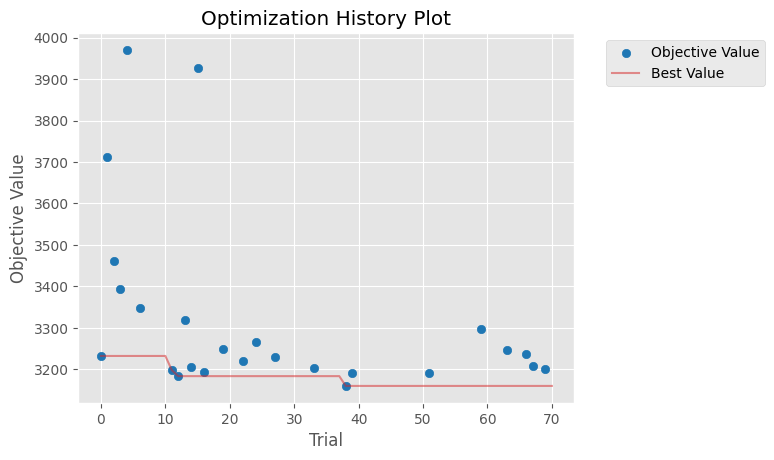

In [163]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study)

2. Gráfico de coordenadas paralelas [1 punto]

<ipython-input-162-0320dc31aba7>:3: ExperimentalWarning:

plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'center': 'Parallel Coordinate Plot'}>

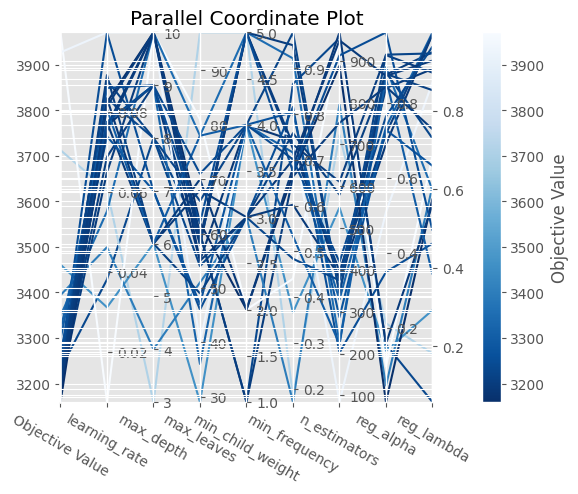

In [162]:
from optuna.visualization.matplotlib import plot_parallel_coordinate

plot_parallel_coordinate(study)

3. Gráfico de importancia de hiperparámetros [1 punto]

<ipython-input-161-b96112f50691>:3: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

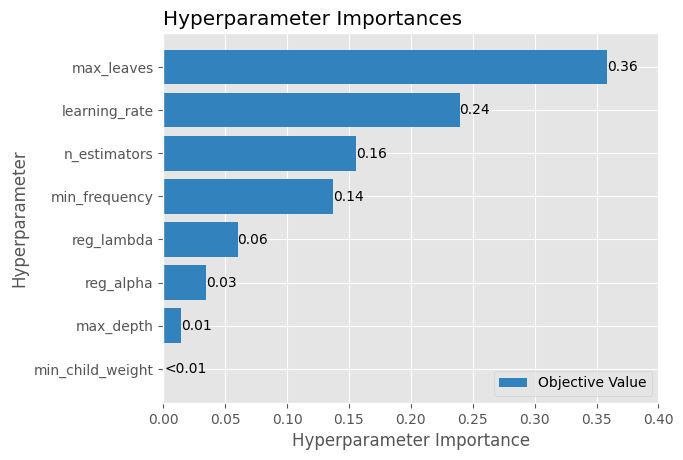

In [161]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study)

4. ¿Desde qué *trial* se empiezan a observar mejoras notables en sus resultados? [0.5 puntos]

En el trial 71 se observan mejoras, luego baja su rendimiento.

5. ¿Qué tendencias puede observar a partir del gráfico de coordenadas paralelas? [1 punto]

No se observa ninguna tendencia clara

6. ¿Cuáles son los hiperparámetros con mayor importancia para la optimización de su modelo? [0.5 puntos]

El max_leaves y learning_rate parecen ser los más importantes

## 6. Síntesis de resultados (3 puntos)

Finalmente:

1. Genere una tabla resumen del MAE en el conjunto de validación obtenido en los 5 modelos entrenados desde Baseline hasta XGBoost con Constraints, Optuna y Prunning. [1 punto]
2. Compare los resultados de la tabla y responda, ¿qué modelo obtiene el mejor rendimiento? [0.5 puntos]
3. Cargue el mejor modelo, prediga sobre el conjunto de **test** y reporte su MAE. [0.5 puntos]
4. ¿Existen diferencias con respecto a las métricas obtenidas en el conjunto de validación? ¿Porqué puede ocurrir esto? [1 punto]



| Parámetro          | Explicación                                                                             |
| ------------------ | --------------------------------------------------------------------------------------- |
| `Baseline`    |13543           |
| `XGBoost`     | 2456         |
| `XGBoost con constraints`        | 2673                     |
| `XGBoost con Optuna`       | 3076                         |
| `XGBoost xon Prunning` | 3159             |



El modelo que tiene mejor rendimiento es el XGBoost sin ninguna mejora

In [173]:
with open("modelo_xgb.pkl", "rb") as f:
    best_pipeline = pickle.load(f)

X_test = test.drop(columns=target)
X_test_dates = date_transformer.fit_transform(X_test['date'])
X_test = X_test.drop(columns='date').join(X_test_dates)
# X_test = preprocessor.transform(X_test)
y_test = test[target]
y_pred_xgb = best_pipeline.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"MAE XGBRegressor: {mae_xgb:.2f}")

MAE XGBRegressor: 2336.77


No existe mucha diferencia con el conjunto de validación

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

<p align="center">
  <img src="https://i.pinimg.com/originals/55/3d/42/553d42bea9b10e0662a05aa8726fc7f4.gif">
</p>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>